# Deep Learning Term Project for ECG (DIL700)

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
import os
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from general_functions import *
import pickle
import json
from keras.models import model_from_json


from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')

## Loading Dataset MIT-BIH

Collect all the data from the csv files

In [2]:
train_df_mitbih=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df_mitbih=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
full_df_mitbih=pd.concat([train_df_mitbih,test_df_mitbih],ignore_index=True)

In [3]:
full_df_mitbih

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109441,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
109442,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
109443,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
109444,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


## Create feautures and labels for dataset MIT-BIH

Create different dataframes for training/testing data and labels.
Also OneHotEncoding for the labels and renaming the classes

In [4]:
train_X_mitbih = train_df_mitbih.iloc[:, :-1]
train_y_mitbih = train_df_mitbih.iloc[:, -1]

train_X_mitbih, valid_X_mitbih, train_y_mitbih, valid_y_mitbih = train_test_split(train_X_mitbih, train_y_mitbih, test_size=0.2, random_state=82)

train_y_nn_mitbih = pd.get_dummies(train_y_mitbih, columns=[1])
train_y_nn_mitbih = train_y_nn_mitbih.rename(columns={0: "N", 1: "S", 2: "V", 3: "F", 4: "Q"})

valid_y_nn_mitbih = pd.get_dummies(valid_y_mitbih, columns=[1])
valid_y_nn_mitbih = valid_y_nn_mitbih.rename(columns={0: "N", 1: "S", 2: "V", 3: "F", 4: "Q"})

test_X_mitbih = test_df_mitbih.iloc[:, :-1]
test_y_mitbih = test_df_mitbih.iloc[:, -1]
test_y_nn_mitbih = pd.get_dummies(test_y_mitbih, columns=[1])
test_y_nn_mitbih = test_y_nn_mitbih.rename(columns={0: "N", 1: "S", 2: "V", 3: "F", 4: "Q"})

## Loading Dataset PTB-DB

Collect all the data from the csv files

In [5]:
normal_df_ptb = pd.read_csv('./Dataset_ptbdb/ptbdb_normal.csv',header=None)
abnormal_df_ptb = pd.read_csv('./Dataset_ptbdb/ptbdb_abnormal.csv',header=None)
# Combine to a full dataset
full_df_ptb = pd.concat([normal_df_ptb, abnormal_df_ptb], axis=0, ignore_index=True)

## Create feautures and labels for dataset PTB-DB

Create different dataframes for training/testing data and labels.
Also OneHotEncoding for the labels and renaming the classes

In [6]:
# Add training valid and test split

# Loading model

In [9]:
path = 'saved_models/RandomForestClassifier_17032023_142604/RandomForestClassifier.pkl'

# Load the pkl file
with open(path, 'rb') as f:
    model = pickle.load(f)

In [10]:
# Evaluate random forest classifier
accuracy = model.score(test_X_mitbih, test_y_mitbih)
print(f'Random forest classifier accuracy: {accuracy:.5f}')

Random forest classifier accuracy: 0.84775


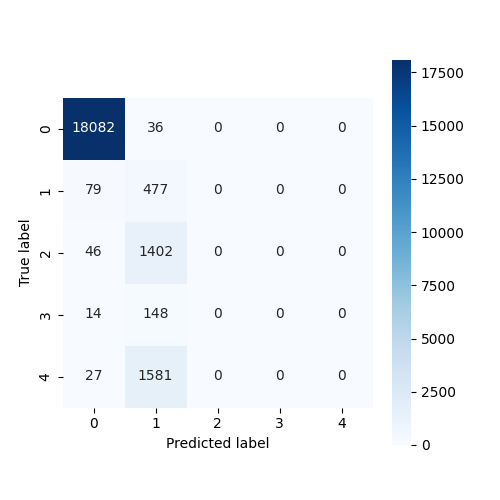

In [11]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Predict test set labels
y_pred_model = model.predict(test_X_mitbih)

# Calculate confusion matrix
cm = confusion_matrix(test_y_mitbih, y_pred_model)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [12]:
print(classification_report(test_y_mitbih, y_pred_model))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     18118
         1.0       0.13      0.86      0.23       556
         2.0       0.00      0.00      0.00      1448
         3.0       0.00      0.00      0.00       162
         4.0       0.00      0.00      0.00      1608

    accuracy                           0.85     21892
   macro avg       0.22      0.37      0.24     21892
weighted avg       0.82      0.85      0.83     21892

